In [1]:
from pathlib import Path

import numpy as np
from IPython.display import Image
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from torch import Tensor

from embeddings.common.log import logger
from embeddings.dataset.tno_dataset_collection import TnoDatasetCollection
from embeddings.inverse_problems.compressed_sensing_problem import TotalEmissionsCompressedSensingExperiment
from embeddings.inverse_problems.footprints.gaussian_plume_model import GaussianPlumeModel
from embeddings.inverse_problems.inverse_problems_solver import (
    SparsityTransform,
    BasisPursuitSolver,
    GenerativeModelSolver,
)
from embeddings.models.common.metrics import ssim, relative_error
from embeddings.plotting.city_emission_field_plot import plot_emission_field_tensor

# Gaussian Plume Simulation

In [2]:
sensor_locations = [
    (5, 5),
    (25, 5),
    (5, 25),
    (25, 25),
    (15, 15),
    (5, 15),
    (15, 5),
    (25, 15),
    (15, 25),
    (10, 10),
    (10, 20),
    (20, 10),
    (20, 20),
]

measurements_per_sensor = 100

In [3]:
model = GaussianPlumeModel()

footprints = []

for sensor_x, sensor_y in sensor_locations:
    footprints += model.get_sensitivities_for_sensor(sensor_x, sensor_y, num_measurements=measurements_per_sensor)

In [4]:
sensing_matrix = np.zeros((len(footprints), 32 * 32))
for i, footprint in enumerate(footprints):
    sensing_matrix[i, :] = footprint.reshape(32 * 32)

vmax = sensing_matrix.max()

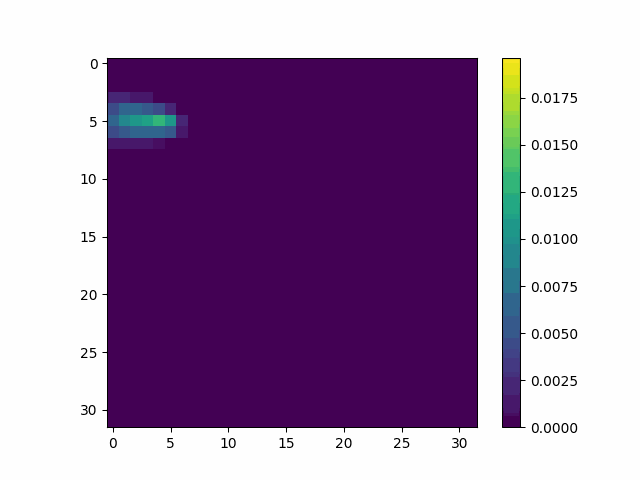

In [5]:
gif_path = Path("generated_animations") / "gaussian_plume.gif"

fig, ax = plt.subplots()

image = ax.imshow(sensing_matrix[0].reshape(32, 32), vmin=0, vmax=vmax)

plt.colorbar(image)

def update(frame):
    image.set_array(sensing_matrix[frame].reshape(32, 32))
    return [image]

ani = FuncAnimation(fig, update, frames=len(sensing_matrix), blit=True, interval=100)

plt.close()

ani.save(gif_path, writer="pillow", fps=30)

Image(filename=gif_path)

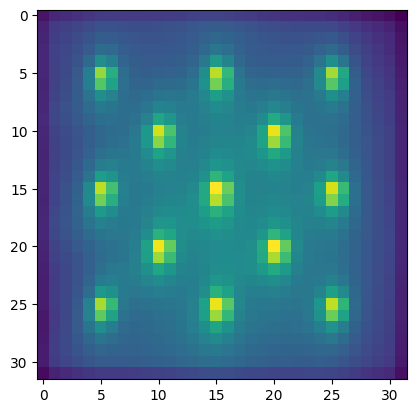

In [6]:
_, ax = plt.subplots()
ax.imshow(sensing_matrix.sum(axis=0).reshape(32, 32))

# Compressed Sensing

In [7]:
CITY = "Munich"

x = TnoDatasetCollection().get_single_case_study_city_emission_field(city=CITY, year=2018).sum(dim=0)

[INFO] > Loading TNO data from '/home/must1d/Repositories/inventory-embeddings/data/TNO-GHGco-1km/TNO_by_city/TNO_GHGco_2015_highres_by_city.csv'
[INFO] > Loading TNO data from '/home/must1d/Repositories/inventory-embeddings/data/TNO-GHGco-1km/TNO_by_city/TNO_GHGco_2018_highres_by_city.csv'
[INFO] > Test Set has 13 unique cites!                          
	Reims, Innsbruck, Szczecin, Hamburg, Aachen, Siegen, Győr, Gdynia, Prague, Großzschocher, Duisburg, Dresden, Magdeburg
[INFO] > Validation Set has 15 unique cites!
	Bydgoszcz, Zielona Góra, Linz, Nijmegen, Angers, Kalisz, Erfurt, Brussels, Frankfurt am Main, Koblenz, Southampton, Wałbrzych, Kassel, Bielefeld, Ingolstadt
[INFO] > Training Set has 74 unique cites!
	Milton Keynes, Ostrava, Sunderland, Antwerpen, Bremen, Koszalin, Köln, Kiel, Mannheim, Legnica, Orléans, Reading, Strasbourg, Nantes, Rotterdam, Vienna, Trier, Southend-on-Sea, Rouen, Tours, Bremerhaven, Heilbronn, Norwich, Hannover, Odense, Kingston upon Hull, Poznań, Hastin

In [8]:
snr = 10_000

problem = TotalEmissionsCompressedSensingExperiment.generate_from_sensing_matrix(
    x,
    Tensor(sensing_matrix),
    snr=snr
)

In [9]:
bp_solver = BasisPursuitSolver(verbose=False)
bp_solver_dwt = BasisPursuitSolver(transform=SparsityTransform.DWT, verbose=False)
bp_solver_dct = BasisPursuitSolver(transform=SparsityTransform.DCT, verbose=False)

gen_solver_256 = GenerativeModelSolver.from_vae_model_name("256", plot_loss=True)
gen_solver_512 = GenerativeModelSolver.from_vae_model_name("512", plot_loss=True)
gen_solver_1024 = GenerativeModelSolver.from_vae_model_name("1024", plot_loss=True)
gen_solver_2048 = GenerativeModelSolver.from_vae_model_name("2048", plot_loss=True)

gen_solver_512_munich = GenerativeModelSolver.from_vae_model_name("512_munich", plot_loss=True)
gen_solver_1024_munich = GenerativeModelSolver.from_vae_model_name("1024_munich", plot_loss=True)
gen_solver_2048_munich = GenerativeModelSolver.from_vae_model_name("2048_munich", plot_loss=True)

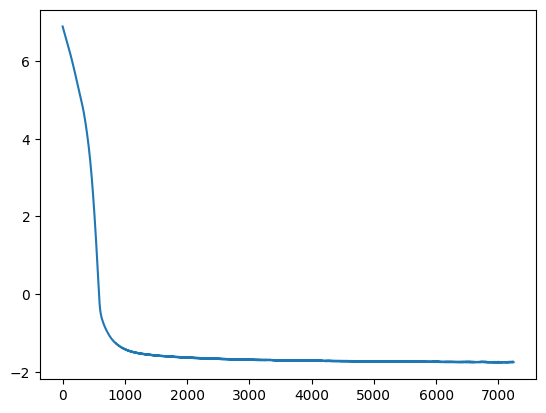

In [10]:
x_rec = problem.solve(gen_solver_1024_munich)

In [11]:
logger.info(f"SSIM={ssim(x, x_rec):.3f}")
logger.info(f"Relative Error={100 * relative_error(x, x_rec):.3f}%")

[INFO] > SSIM=0.851
[INFO] > Relative Error=29.355%


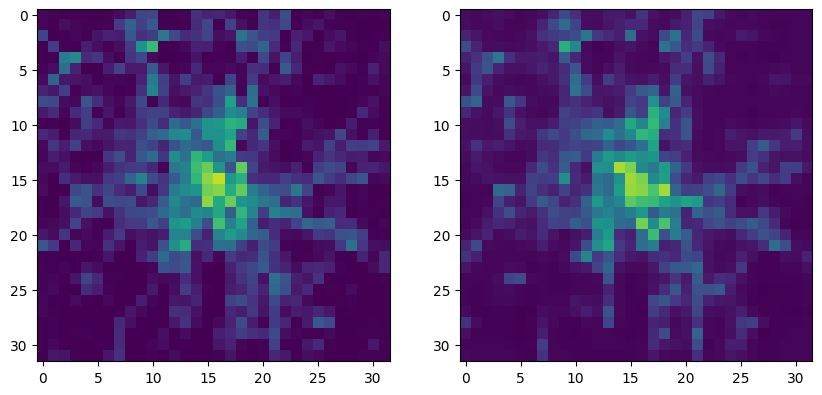

In [12]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

vmax = 1.1 * float(x.max())

plot_emission_field_tensor(ax=ax1, emission_field=x, vmax=vmax)
plot_emission_field_tensor(ax=ax2, emission_field=x_rec, vmax=vmax)